In [1]:
import pandas as pd
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

data_path = 'data/'

### Import Data

In [192]:
tino = pd.read_csv(data_path+'tarantino.csv')
tino['primary_key'] = tino.index
tino['type_count'] = tino.groupby(['movie','type']).cumcount()+1
tino['death_caused_by_word'] = np.zeros(len(tino))

word = pysqldf("SELECT * FROM tino WHERE type='word'")
death = pysqldf("SELECT * FROM tino WHERE type='death'")
movies = tino.movie.unique()

### Exploratory Plots
What are the most commonly used cuss words in Tarrantino films?

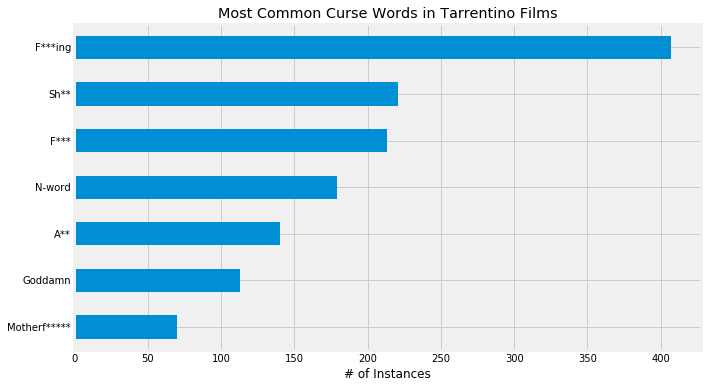

In [193]:
tino.word.value_counts()[:7].plot.barh(figsize=(10,6))
plt.gca().invert_yaxis()
plt.title("Most Common Curse Words in Tarrentino Films")
locs, labels = plt.yticks()
plt.yticks(locs,["F***ing","Sh**","F***","N-word","A**","Goddamn","Motherf*****"]);
plt.xlabel("# of Instances");

### Is there a relationship between cussing and killing in his movies?

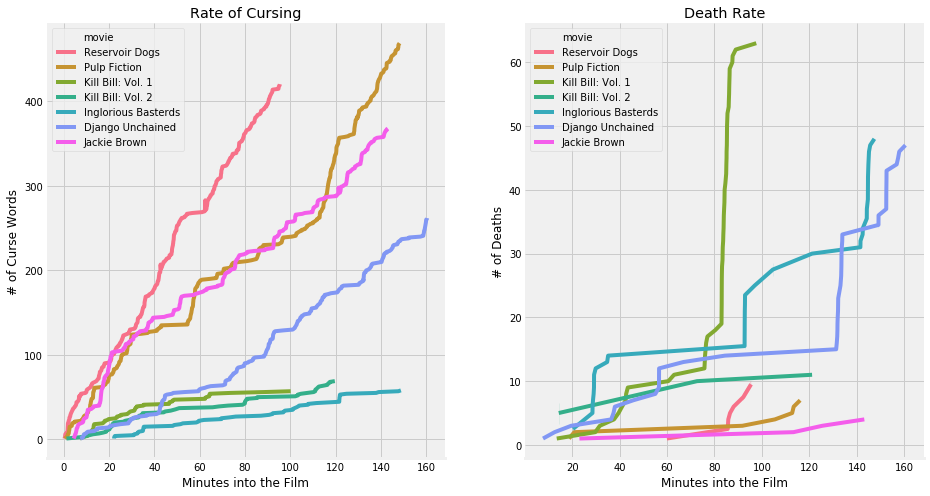

In [194]:
f, axes = plt.subplots(1,2,figsize=(14,8))
sns.despine(left=True)

sns.lineplot(data=word,x='minutes_in',y='type_count',hue='movie',ax=axes[0])
axes[0].set_xlabel("Minutes into the Film")
axes[0].set_ylabel("# of Curse Words");
axes[0].set_title("Rate of Cursing")

sns.lineplot(data=death,x='minutes_in',y='type_count',hue='movie',ax=axes[1])
axes[1].set_xlabel("Minutes into the Film")
axes[1].set_ylabel("# of Deaths");
axes[1].set_title("Death Rate");

### Rank the Movies by Death/Curse ratio.

In [195]:
number_of_deaths = pysqldf("""SELECT movie, COUNT(primary_key) AS num_deaths 
                           FROM tino 
                           WHERE type='death' 
                           GROUP BY movie""")

number_of_words = pysqldf("""SELECT movie, COUNT(primary_key) AS num_words 
                          FROM tino 
                          WHERE type='word' 
                          GROUP BY movie""")

deaths_per_curse = pysqldf("""SELECT * FROM number_of_deaths 
            INNER JOIN number_of_words 
            ON number_of_deaths.movie=number_of_words.movie
            ORDER BY movie""")

deaths_per_curse = deaths_per_curse.loc[:,~deaths_per_curse.columns.duplicated()]
deaths_per_curse['ratio'] = deaths_per_curse['num_deaths']/deaths_per_curse['num_words']

deaths_per_curse.sort_values("ratio",ascending=False)

,movie,num_deaths,num_words,ratio
3,Kill Bill: Vol. 1,63,57,1.105263
1,Inglorious Basterds,48,58,0.827586
0,Django Unchained,47,262,0.179389
4,Kill Bill: Vol. 2,11,69,0.159420
6,Reservoir Dogs,10,421,0.023753
5,Pulp Fiction,7,469,0.014925
2,Jackie Brown,4,368,0.010870


## If the curse word is used within 1 minute of the death, we will say it 'indicated' death.
If the word causes at least one death, we award it 1 point.  To eliminate bias from Kill Bill Vol. 1, Django Unchained, and Inglorious Basterd's mass murders, a word that causes 1 death or 10+ deaths at once is worth the same.

In [196]:
for row in death[['minutes_in','primary_key','movie','death_caused_by_word']].iterrows():
    end = row[1]['primary_key']
    time_of_death = row[1]['minutes_in']
    movie = row[1]['movie']
    
    tino['death_caused_by_word'] += (tino.where((tino['primary_key']<end) & (tino['movie']==movie) & 
    (tino['minutes_in']<time_of_death) & (tino['death_caused_by_word']!=1) &  
    (time_of_death - tino['minutes_in'] <= 1.0))['death_caused_by_word']+1).fillna(0)

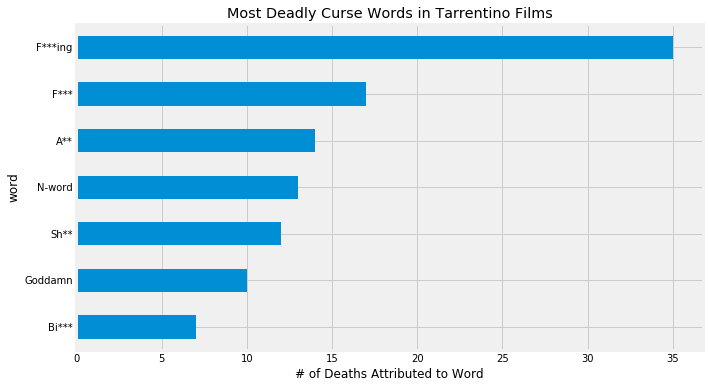

In [207]:
tino[['word','death_caused_by_word']].groupby("word").sum().sort_values("death_caused_by_word",ascending=False)['death_caused_by_word'][:7].plot(kind='barh',figsize=(10,6));
plt.gca().invert_yaxis()
plt.title("Most Deadly Curse Words in Tarrentino Films")
locs, labels = plt.yticks()
plt.yticks(locs,["F***ing","F***","A**","N-word","Sh**","Goddamn","Bi***"])
plt.xlabel("# of Deaths Attributed to Word");